In [1]:
import pandas as pd
import numpy as np
from glob import glob

In [2]:
def aggregate_csvs(csvs):
    dfs = []
    for c in csvs:
        df_ = pd.read_csv(c)
        df_['fold'] = c.split('_')[-1].split('.')[0]
        dfs.append(df_)
    df_all = pd.concat(dfs, axis=0)
    return df_all

In [3]:
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy import stats
import numpy as np
import math

def median_confidence_interval_bounds(n, confidence_level=0.95):
    """
    Calculate the positions (j, k) for confidence interval bounds of a population median.
    
    Parameters:
    -----------
    n : int
        Sample size
    confidence_level : float, default=0.95
        Confidence level (e.g., 0.95 for 95% confidence interval)
    
    Returns:
    --------
    tuple
        (j, k) where j and k are the positions (1-indexed) of the lower and upper bounds
        in the ordered sample data
    
    Example:
    --------
    >>> j, k = median_confidence_interval_bounds(20, 0.95)
    >>> print(f"95% CI bounds are at positions {j} and {k}")
    """
    # For median, q = 0.5
    q = 0.5
    
    # Calculate z-critical value for given confidence level
    alpha = 1 - confidence_level
    z = stats.norm.ppf(1 - alpha/2)
    
    # Calculate nq and the standard error term
    nq = n * q
    se_term = z * math.sqrt(n * q * (1 - q))
    
    # Calculate j and k
    j_raw = nq - se_term
    k_raw = nq + se_term
    
    # Round up to next integer (ceiling)
    j = math.ceil(j_raw)
    k = math.ceil(k_raw)
    
    # Ensure bounds are within valid range [1, n]
    j = max(1, j)
    k = min(n, k)
    
    return j, k

def get_median_confidence_interval(data, confidence_level=0.95):
    """
    Get the actual confidence interval for the median from sample data.
    
    Parameters:
    -----------
    data : list or array-like
        Sample data
    confidence_level : float, default=0.95
        Confidence level
    
    Returns:
    --------
    tuple
        (lower_bound, upper_bound) - the actual values from the data
    
    Example:
    --------
    >>> data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    >>> lower, upper = get_median_confidence_interval(data, 0.95)
    >>> print(f"95% CI for median: [{lower}, {upper}]")
    """
    # Sort the data
    sorted_data = sorted(data)
    n = len(sorted_data)
    
    # Get the positions
    j, k = median_confidence_interval_bounds(n, confidence_level)
    
    # Return the actual values (convert to 0-indexed)
    lower_bound = sorted_data[j - 1]
    upper_bound = sorted_data[k - 1]
    
    return lower_bound, upper_bound

def get_mean_confidence_interval(data, confidence_level=0.95):
    """
    Get the confidence interval for the mean from sample data using t-distribution.
    
    Parameters:
    -----------
    data : list or array-like
        Sample data
    confidence_level : float, default=0.95
        Confidence level
    
    Returns:
    --------
    tuple
        (lower_bound, upper_bound) - the confidence interval bounds for the mean
    """
    data = np.array(data)
    n = len(data)
    mean_val = np.mean(data)
    std_val = np.std(data, ddof=1)  # Sample standard deviation
    
    # Calculate confidence interval using t-distribution
    alpha = 1 - confidence_level
    t_critical = stats.t.ppf(1 - alpha/2, n - 1)
    standard_error = std_val / np.sqrt(n)
    margin_of_error = t_critical * standard_error
    
    lower_bound = mean_val - margin_of_error
    upper_bound = mean_val + margin_of_error
    
    return lower_bound, upper_bound

def calculate_cv_classification_metrics(df, label_col='labels', prob_col='probs', fold_col='fold', 
                                      use_median=True, confidence_level=0.95):
    """
    Calculate AUROC, AUPRC and their confidence intervals across CV folds.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the results with labels, probabilities, and fold information
    label_col : str, default='labels'
        Column name containing true labels
    prob_col : str, default='probs' 
        Column name containing predicted probabilities
    fold_col : str, default='fold'
        Column name containing fold numbers
    use_median : bool, default=True
        If True, calculate median and its CI. If False, calculate mean and its CI.
    confidence_level : float, default=0.95
        Confidence level for the intervals
    
    Returns:
    --------
    dict : Dictionary containing metrics and confidence intervals
    """
    
    # Get unique folds
    folds = sorted(df[fold_col].unique())
    
    auroc_scores = []
    auprc_scores = []
    
    # Calculate metrics for each fold
    for fold in folds:
        fold_data = df[df[fold_col] == fold]
        
        y_true = fold_data[label_col].values
        y_prob = fold_data[prob_col].values
        
        # Calculate AUROC
        auroc = roc_auc_score(y_true, y_prob)
        auroc_scores.append(auroc)
        
        # Calculate AUPRC (Average Precision)
        auprc = average_precision_score(y_true, y_prob)
        auprc_scores.append(auprc)
    
    # Convert to numpy arrays
    auroc_scores = np.array(auroc_scores)
    auprc_scores = np.array(auprc_scores)

    if len(auroc_scores) != 5 or len(auprc_scores) != 5:
        print('cv error: expected 5 folds')
        if use_median:
            central_measure = 'median'
        else:
            central_measure = 'mean'
            
        results = {
            'auroc': {
                central_measure: np.nan,
                'ci_lower': np.nan,
                'ci_upper': np.nan,
                'fold_scores': np.nan
            },
            'auprc': {
                central_measure: np.nan,
                'ci_lower': np.nan,
                'ci_upper': np.nan,
                'fold_scores': np.nan
            }
        }
        return results
    
    else:
    
        # Calculate central tendency and confidence intervals
        if use_median:
            # Calculate medians
            central_auroc = np.median(auroc_scores)
            central_auprc = np.median(auprc_scores)
            
            # Calculate confidence intervals for median
            auroc_ci_lower, auroc_ci_upper = get_median_confidence_interval(auroc_scores, confidence_level=confidence_level)
            auprc_ci_lower, auprc_ci_upper = get_median_confidence_interval(auprc_scores, confidence_level=confidence_level)
            
            central_measure = 'median'
        else:
            # Calculate means
            central_auroc = np.mean(auroc_scores)
            central_auprc = np.mean(auprc_scores)
            
            # Calculate confidence intervals for mean
            auroc_ci_lower, auroc_ci_upper = get_mean_confidence_interval(auroc_scores, confidence_level=confidence_level)
            auprc_ci_lower, auprc_ci_upper = get_mean_confidence_interval(auprc_scores, confidence_level=confidence_level)
            
            central_measure = 'mean'
        
        # Prepare results
        results = {
            'auroc': {
                central_measure: central_auroc,
                'ci_lower': auroc_ci_lower,
                'ci_upper': auroc_ci_upper,
                'fold_scores': auroc_scores.tolist()
            },
            'auprc': {
                central_measure: central_auprc,
                'ci_lower': auprc_ci_lower,
                'ci_upper': auprc_ci_upper,
                'fold_scores': auprc_scores.tolist()
            }
        }
        
        return results

def calculate_cv_segmentation_metrics(df, metric_names=['iou','dice'], confidence_level=0.95, 
                                    fold_col='fold', use_median=True):
    """
    Calculate cross-validation metrics with confidence intervals for segmentation tasks.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the results with metrics and fold information
    metric_names : list
        List of metric column names to calculate (e.g., ['iou', 'dice'])
    confidence_level : float
        Confidence level for the intervals (0-1)
    fold_col : str
        Column name containing fold numbers
    use_median : bool, default=True
        If True, calculate median and its CI. If False, calculate mean and its CI.
    
    Returns:
    --------
    dict
        Dictionary with CV results for each metric
    """
    results = {}
    
    # Get unique folds
    folds = sorted(df[fold_col].unique())
    
    # Calculate metrics for each fold
    for metric_name in metric_names:
        cv_value_list = []
        for fold in folds:          
            df_sub = df[df[fold_col] == fold]
            
            # Convert to numpy array if not already
            metric_values_ = np.array(df_sub[metric_name])
            mean_value_ = np.mean(metric_values_)
            cv_value_list.append(mean_value_)

        if len(cv_value_list) != 5:
            
            if use_median:
                central_measure = 'median'
            else:
                central_measure = 'mean'
                
            # Store results
            results[metric_name] = {
                central_measure: np.nan,
                'ci_lower': np.nan,
                'ci_upper': np.nan,
                'fold_scores': np.nan
            }
        else:
            # Calculate central tendency and confidence intervals
            if use_median:
                # Calculate median
                central_value = np.median(cv_value_list)
                
                # Calculate confidence intervals for median
                lower_ci, upper_ci = get_median_confidence_interval(cv_value_list, confidence_level=confidence_level)
                
                central_measure = 'median'
            else:
                # Calculate mean
                central_value = np.mean(cv_value_list)
                
                # Calculate confidence intervals for mean
                lower_ci, upper_ci = get_mean_confidence_interval(cv_value_list, confidence_level=confidence_level)
                
                central_measure = 'mean'
            
            # Store results
            results[metric_name] = {
                central_measure: central_value,
                'ci_lower': lower_ci,
                'ci_upper': upper_ci,
                'fold_scores': cv_value_list
            }
    
    return results

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette('Set2', 3)
import numpy as np

def detect_central_measure(results_dict):
    """
    Detect whether the results dictionary contains 'mean' or 'median' data.
    
    Parameters:
    -----------
    results_dict : dict
        Nested dictionary with CV results
    
    Returns:
    --------
    str
        Either 'mean' or 'median'
    """
    # Navigate to the first available metric data
    for condition in results_dict.values():
        for model in condition.values():
            for method in model.values():
                for metric_data in method.values():
                    if isinstance(metric_data, dict):
                        if 'mean' in metric_data:
                            return 'mean'
                        elif 'median' in metric_data:
                            return 'median'
    raise ValueError("Could not detect central measure ('mean' or 'median') in results dictionary")

def plot_confidence_intervals_bars(results_dict, condition=None, metric='auroc', 
                                 figsize=(18, 9), font_size=12, palette='Set2',
                                 method_labels=None, ylim=None, save_path=None,
                                 highlight_models=None, highlight_color='red',
                                 highlight_label=None, central_measure=None):
    """
    Plot confidence intervals for all models and methods using bar plots with the same style 
    as plot_metric_by_freeze function. Automatically detects whether to use mean or median.
    
    Parameters:
    -----------
    results_dict : dict
        Nested dictionary with CV results (your current format)
    condition : str, optional
        Specific condition to plot. If None, plots all conditions
    metric : str
        Which metric to plot ('auroc' or 'auprc')
    figsize : tuple
        Figure size (width, height)
    font_size : int or float
        Font size for all text elements in the plot
    palette : str, default 'Set2'
        Color palette for different methods
    method_labels : dict, optional
        Custom labels for methods {'Linear Probing': 'LP', 'Fine-tuning': 'FT'}
    ylim : tuple, optional
        Y-axis limits (min, max). If None, uses automatic scaling based on data
    save_path : str, optional
        Path to save the plot
    highlight_models : list or str, optional
        Models to highlight with different color. Can be:
        - 'last': highlight only the last model
        - list of model names: highlight specific models
        - None: no highlighting
    highlight_color : str, default 'red'
        Color to use for highlighted model bars
    highlight_label : str, optional
        Custom label for highlighted models in legend. If None, auto-generates label
    central_measure : str, optional
        Either 'mean' or 'median'. If None, automatically detects from data
    """
    # Auto-detect central measure if not specified
    if central_measure is None:
        central_measure = detect_central_measure(results_dict)
    
    # Default method labels
    if method_labels is None:
        method_labels = {'Linear Probing': 'Linear Probing', 'Fine-tuning': 'Fine-tuning'}
    
    conditions_to_plot = [condition] if condition else list(results_dict.keys())
    
    # Create subplots
    n_conditions = len(conditions_to_plot)
    n_cols = min(3, n_conditions)  # Max 3 columns
    n_rows = (n_conditions + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False, sharey=True, dpi=300)
    
    for idx, cond in enumerate(conditions_to_plot):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        models = list(results_dict[cond].keys())
        all_methods = list(results_dict[cond][models[0]].keys())
        
        # Ensure Linear Probing comes before Fine-tuning
        methods = []
        if 'Linear Probing' in all_methods:
            methods.append('Linear Probing')
        if 'Fine-tuning' in all_methods:
            methods.append('Fine-tuning')
        # Add any other methods that might exist
        for method in all_methods:
            if method not in methods:
                methods.append(method)
        
        # Create color palette for methods
        colors = sns.color_palette(palette, len(methods))
        color_map = dict(zip(methods, colors))
        
        # Set up positions
        x_positions = np.arange(len(models))
        width = 0.8 / len(methods)
        
        # Plot for each method
        for i, method in enumerate(methods):
            central_values = []
            ci_lower = []
            ci_upper = []
            method_positions = []
            
            for j, model in enumerate(models):
                data = results_dict[cond][model][method][metric]
                central_values.append(data[central_measure])
                ci_lower.append(data['ci_lower'])
                ci_upper.append(data['ci_upper'])
                method_positions.append(x_positions[j] + i * width - width * (len(methods) - 1) / 2)
            
            # Calculate error bars (distance from center to bounds)
            yerr_lower = np.array(central_values) - np.array(ci_lower)
            yerr_upper = np.array(ci_upper) - np.array(central_values)
            yerr = [yerr_lower, yerr_upper]
            
            # Determine which models to highlight
            models_to_highlight = []
            if highlight_models == 'last':
                models_to_highlight = [models[-1]]
            elif isinstance(highlight_models, list):
                models_to_highlight = highlight_models
            elif isinstance(highlight_models, str) and highlight_models != 'last':
                models_to_highlight = [highlight_models]
            
            # Determine colors for each bar
            bar_colors = []
            for j, model in enumerate(models):
                if model in models_to_highlight:
                    bar_colors.append(highlight_color)
                else:
                    bar_colors.append(color_map[method])
            
            # Plot bars with error bars
            method_label = method_labels.get(method, method)
            bars = ax.bar(method_positions, central_values, width,
                         label=method_label,
                         color=bar_colors,
                         alpha=0.8,
                         capsize=3)
            
            # Add error bars
            ax.errorbar(method_positions, central_values,
                       yerr=yerr, fmt='none',
                       color='black', capsize=3, capthick=1)
            
            # Add value labels on bars
            for j, (pos, central_val, upper_val) in enumerate(zip(method_positions, central_values, ci_upper)):
                ax.text(pos, upper_val + 0.005, f'{central_val:.2f}',
                       ha='center', va='bottom', fontsize=font_size-4, rotation=0)
        
        # Customize subplot
        if idx == 0:  # Only add ylabel to the first subplot
            ylabel = f"{metric.upper()}"
            ax.set_ylabel(ylabel, fontsize=font_size)
        
        ax.set_title(f'{cond}', fontsize=font_size)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(models, rotation=45, ha='right', fontsize=font_size)
        ax.tick_params(axis='both', which='major', labelsize=font_size)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Create legend with method colors and highlighted models
        legend_elements = []
        
        # Add method legend entries
        for method in methods:
            method_label = method_labels.get(method, method)
            legend_elements.append(plt.Rectangle((0,0),1,1, 
                                               facecolor=color_map[method], 
                                               alpha=0.8, 
                                               label=method_label))
        
        # Add highlighted models legend entry if applicable
        models_to_highlight = []
        if highlight_models == 'last':
            models_to_highlight = [models[-1]]
        elif isinstance(highlight_models, list):
            models_to_highlight = highlight_models
        elif isinstance(highlight_models, str) and highlight_models != 'last':
            models_to_highlight = [highlight_models]
        
        if models_to_highlight:
            if highlight_label:
                legend_label = highlight_label
            elif len(models_to_highlight) == 1 and highlight_models == 'last':
                legend_label = f"Highlighted ({models_to_highlight[0]})"
            elif len(models_to_highlight) == 1:
                legend_label = f"Highlighted ({models_to_highlight[0]})"
            else:
                legend_label = "Highlighted Models"
            
            legend_elements.append(plt.Rectangle((0,0),1,1, 
                                               facecolor=highlight_color, 
                                               alpha=0.8, 
                                               label=legend_label))
        
        ax.legend(handles=legend_elements, loc='lower right', fontsize=font_size-1)
        
        # Set y-axis limits
        if ylim is not None:
            ax.set_ylim(ylim)
        else:
            # Automatic y-axis limits for better visualization
            all_values = []
            for model in models:
                for method in methods:
                    data = results_dict[cond][model][method][metric]
                    all_values.extend([data['ci_lower'], data['ci_upper']])
            
            margin = (max(all_values) - min(all_values)) * 0.05
            ax.set_ylim(min(all_values) - margin, max(all_values) + margin * 2)  # Extra margin on top for labels
    
    # Hide empty subplots
    total_subplots = n_rows * n_cols
    for idx in range(n_conditions, total_subplots):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig, axes


def print_model_comparison_table(results_dict, metric='auroc', central_measure=None):
    """
    Print a formatted table comparing all models and methods. 
    Automatically detects whether to use mean or median.
    
    Parameters:
    -----------
    results_dict : dict
        Nested dictionary with CV results (your current format)
    metric : str
        Which metric to display ('auroc' or 'auprc')
    central_measure : str, optional
        Either 'mean' or 'median'. If None, automatically detects from data
    """
    # Auto-detect central measure if not specified
    if central_measure is None:
        central_measure = detect_central_measure(results_dict)
    
    print(f"\n{metric.upper()} Performance Comparison ({central_measure.capitalize()})")
    print("=" * 60)
    
    for condition in results_dict.keys():
        print(f"\n{condition}:")
        print("-" * 40)
        
        models = list(results_dict[condition].keys())
        all_methods = list(results_dict[condition][models[0]].keys())
        
        # Ensure Linear Probing comes before Fine-tuning
        methods = []
        if 'Linear Probing' in all_methods:
            methods.append('Linear Probing')
        if 'Fine-tuning' in all_methods:
            methods.append('Fine-tuning')
        # Add any other methods that might exist
        for method in all_methods:
            if method not in methods:
                methods.append(method)
        
        # Create table
        data = []
        for model in models:
            row = [model]
            for method in methods:
                result = results_dict[condition][model][method][metric]
                central_val = result[central_measure]
                ci_lower = result['ci_lower']
                ci_upper = result['ci_upper']
                row.append(f"{central_val:.3f} ({ci_lower:.3f}-{ci_upper:.3f})")
            data.append(row)
        
        # Print table
        headers = ['Model'] + methods
        col_widths = [max(len(str(item)) for item in col) for col in zip(headers, *data)]
        
        # Print header
        header_row = " | ".join(h.ljust(w) for h, w in zip(headers, col_widths))
        print(header_row)
        print("-" * len(header_row))
        
        # Print data rows
        for row in data:
            print(" | ".join(str(item).ljust(w) for item, w in zip(row, col_widths)))


def save_model_comparison_table_csv(results_dict, metric='auroc', filename='model_comparison.csv', 
                                   central_measure=None):
    """
    Save the model comparison table as a CSV file. 
    Automatically detects whether to use mean or median.
    
    Parameters:
    -----------
    results_dict : dict
        Nested dictionary with CV results (your current format)
    metric : str
        Which metric to display ('auroc' or 'auprc')
    filename : str
        Name of the CSV file to save
    central_measure : str, optional
        Either 'mean' or 'median'. If None, automatically detects from data
    """
    import pandas as pd
    
    # Auto-detect central measure if not specified
    if central_measure is None:
        central_measure = detect_central_measure(results_dict)
    
    all_rows = []
    
    for condition in results_dict.keys():
        models = list(results_dict[condition].keys())
        all_methods = list(results_dict[condition][models[0]].keys())
        
        # Ensure Linear Probing comes before Fine-tuning
        methods = []
        if 'Linear Probing' in all_methods:
            methods.append('Linear Probing')
        if 'Fine-tuning' in all_methods:
            methods.append('Fine-tuning')
        # Add any other methods that might exist
        for method in all_methods:
            if method not in methods:
                methods.append(method)
        
        # Create table data for this condition
        for model in models:
            row = {'Condition': condition, 'Model': model, 'Central_Measure': central_measure}
            for method in methods:
                result = results_dict[condition][model][method][metric]
                central_val = result[central_measure]
                ci_lower = result['ci_lower']
                ci_upper = result['ci_upper']
                row[method] = f"{central_val:.3f} ({ci_lower:.3f}-{ci_upper:.3f})"
                
                # Also add separate columns for easier analysis
                row[f"{method}_{central_measure}"] = central_val
                row[f"{method}_CI_Lower"] = ci_lower
                row[f"{method}_CI_Upper"] = ci_upper
            all_rows.append(row)
    
    # Create DataFrame and save
    df = pd.DataFrame(all_rows)
    df.to_csv(filename, index=False)
    print(f"Table saved as {filename} (using {central_measure})")
    #return df

### Classification

In [5]:
cla_csvs = glob('./results/*_cla_*.csv')
len(cla_csvs)

170

In [6]:
results = aggregate_csvs(cla_csvs)
#results['target'] = results.model.apply(lambda x: 'cardiomegaly' if '_cm_' in x else 'pneumothorax')
results['model_names'] = results.model.apply(lambda x: x.split('_')[0])

freeze_options = [1, 0]
freeze_dict = {0:'Fine-tuning', 1:'Linear Probing'}
target_options = ['pneumothorax','cardiomegaly']
target_dict = {'pneumothorax':'Pneumothorax','cardiomegaly':'Cardiomegaly'}
model_options = ['Ark+', 'BiomedCLIP', 'CheXagent', 'MedImageInsights', 'MedSigLIP', 'RAD-DINO', 'DINOv2', 'SigLIP2', 'SegFormer']

cla_cv_results_dict0 = {}

for t in target_options:
    cla_cv_results_dict1 = {}
    for m in model_options:
        cla_cv_results_dict2 = {}
        for f in freeze_options:
    
            sub_results = results[(results.model_names==m)&(results.freeze==f)&(results.target==t)]
            
            cv_results = calculate_cv_classification_metrics(sub_results, label_col='labels', prob_col='probs', fold_col='fold')
    
            cla_cv_results_dict2[freeze_dict[f]] = cv_results
        cla_cv_results_dict1[m] = cla_cv_results_dict2
    cla_cv_results_dict0[target_dict[t]] = cla_cv_results_dict1

cv error: expected 5 folds
cv error: expected 5 folds


In [7]:
cv_scores_list = []
for t in ['Pneumothorax','Cardiomegaly']:
    for m in model_options:
        for f in ['Linear Probing','Fine-tuning']:
            for p in ['auroc','auprc']:
                #print(m,f,p)
                #print(cla_cv_results_dict0[t][m][f][p]['fold_scores'])
                try:
                    df_temp = pd.DataFrame(cla_cv_results_dict0[t][m][f][p]['fold_scores'], columns=['cv_scores'])
                    df_temp['freeze'] = f
                    df_temp['target'] = t
                    df_temp['metric'] = p
                    df_temp['model'] = m
                    cv_scores_list.append(df_temp)
                except:
                    print(f'no data for {m}, {f}, {p}')
                    
results_cla = pd.concat(cv_scores_list, axis=0)
results_cla.to_csv('./stats/3_cv_scores_cla.csv', index=False)              

no data for SegFormer, Linear Probing, auroc
no data for SegFormer, Linear Probing, auprc
no data for SegFormer, Linear Probing, auroc
no data for SegFormer, Linear Probing, auprc


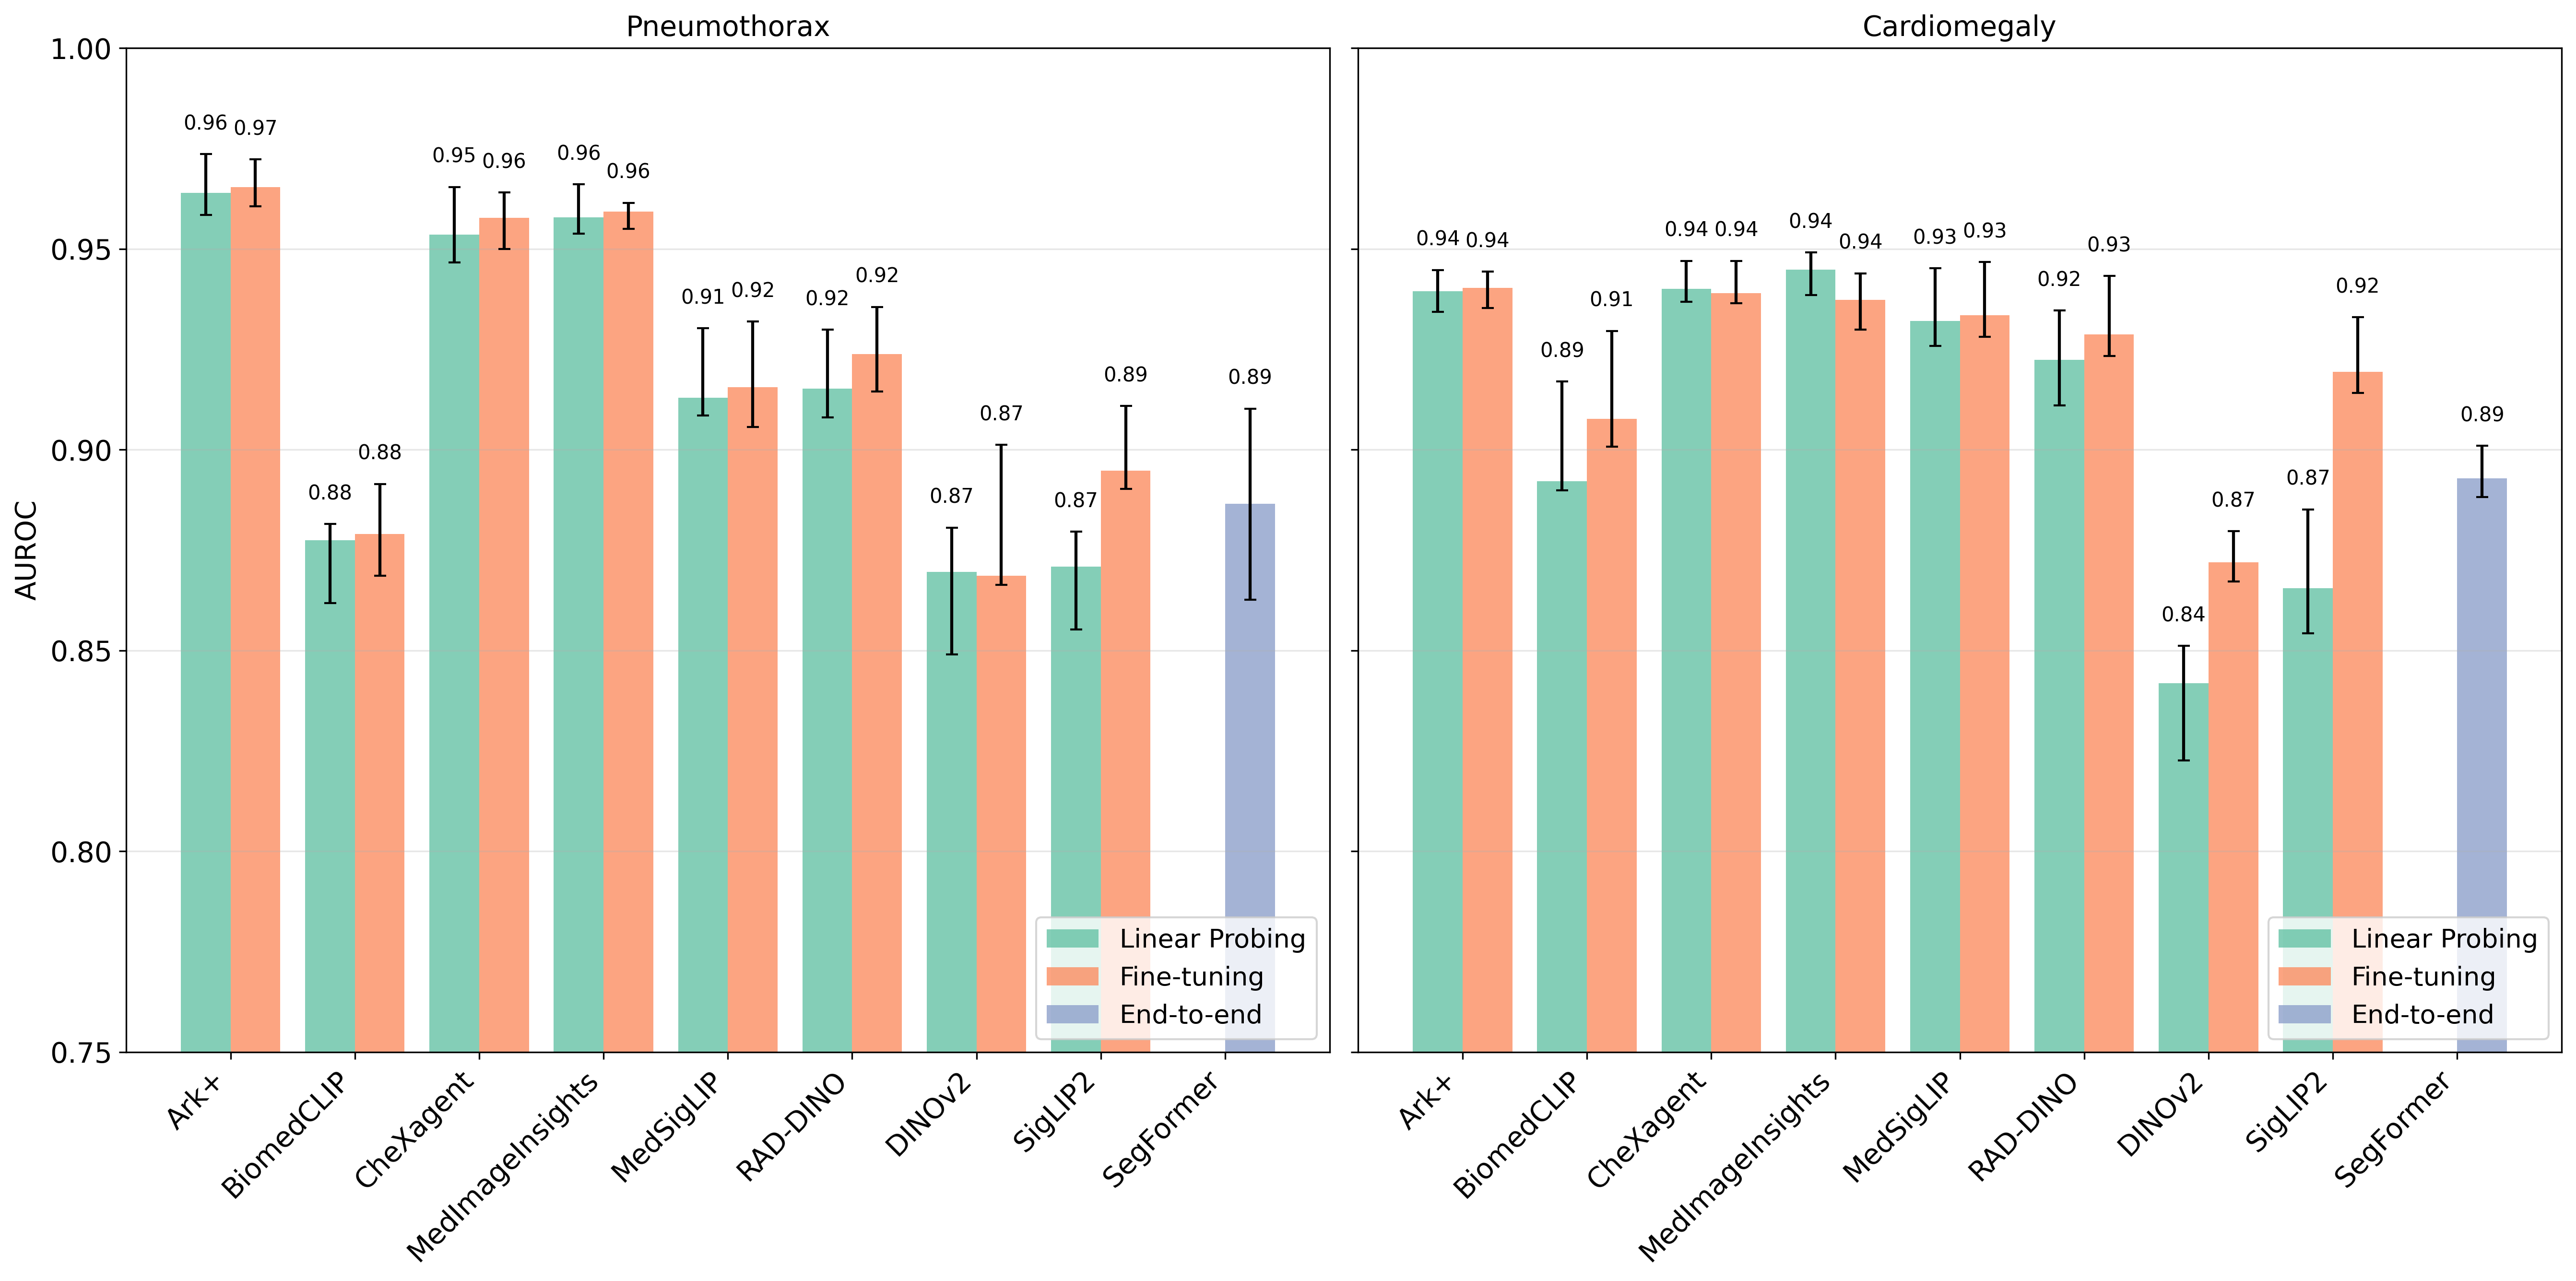


AUROC Performance Comparison (Median)

Pneumothorax:
----------------------------------------
Model            | Linear Probing      | Fine-tuning        
------------------------------------------------------------
Ark+             | 0.964 (0.958-0.974) | 0.965 (0.961-0.972)
BiomedCLIP       | 0.877 (0.862-0.881) | 0.879 (0.869-0.891)
CheXagent        | 0.954 (0.947-0.965) | 0.958 (0.950-0.964)
MedImageInsights | 0.958 (0.954-0.966) | 0.959 (0.955-0.961)
MedSigLIP        | 0.913 (0.908-0.930) | 0.916 (0.906-0.932)
RAD-DINO         | 0.915 (0.908-0.930) | 0.924 (0.914-0.936)
DINOv2           | 0.870 (0.849-0.881) | 0.869 (0.866-0.901)
SigLIP2          | 0.871 (0.855-0.880) | 0.895 (0.890-0.911)
SegFormer        | nan (nan-nan)       | 0.887 (0.863-0.910)

Cardiomegaly:
----------------------------------------
Model            | Linear Probing      | Fine-tuning        
------------------------------------------------------------
Ark+             | 0.939 (0.934-0.945) | 0.940 (0.935-0.

In [8]:
#Plot confidence intervals for AUROC
plot_confidence_intervals_bars(cla_cv_results_dict0, metric='auroc', font_size=14, ylim=(0.75,1.0), highlight_models=['SegFormer'], highlight_color=colors[2], highlight_label='End-to-end')

#Plot confidence intervals for AUPRC  
#plot_confidence_intervals_bars(cla_cv_results_dict0, metric='auprc', font_size=14, ylim=(0.75,1.0), highlight_models=['SegFormer'], highlight_color=colors[2], highlight_label='End-to-end')

#Print comparison tables
print_model_comparison_table(cla_cv_results_dict0, metric='auroc')
#print_model_comparison_table(cla_cv_results_dict0, metric='auprc')


save_model_comparison_table_csv(cla_cv_results_dict0, metric='auroc', filename='./stats/3_auroc_comparison_cla.csv')
#save_model_comparison_table_csv(results, metric='auprc', filename='./stats/auprc_comparison_cla.csv')

### Segmentation

In [6]:
seg_csvs = glob('./results/*_seg_*.csv')
len(seg_csvs)

210

In [7]:
results = aggregate_csvs(seg_csvs)
#results['target'] = results.model.apply(lambda x: 'cardiomegaly' if '_cm_' in x else 'pneumothorax')
results['model_names'] = results.model.apply(lambda x: x.split('_')[0])

freeze_options = [1, 0]
freeze_dict = {1:'Linear Probing', 0:'Fine-tuning'}
target_options = ['pneumothorax','cardiomegaly']
target_dict = {'pneumothorax':'Pneumothorax','cardiomegaly':'Heart'}
model_options = ['Ark+(16)', 'BiomedCLIP', 'CheXagent', 'MedImageInsights(16)', 'MedSigLIP', 'RAD-DINO', 'DINOv2', 'SigLIP2', 'SegFormer'] # ['Ark+(32)','MedImageInsights(32)']

seg_cv_results_dict0 = {}

for t in target_options:
    seg_cv_results_dict1 = {}
    for m in model_options:
        seg_cv_results_dict2 = {}
        for f in freeze_options:
    
            sub_results = results[(results.model_names==m)&(results.freeze==f)&(results.target==t)]
            
            cv_results = calculate_cv_segmentation_metrics(sub_results)
    
            seg_cv_results_dict2[freeze_dict[f]] = cv_results
        seg_cv_results_dict1[m] = seg_cv_results_dict2
    seg_cv_results_dict0[target_dict[t]] = seg_cv_results_dict1

In [8]:
cv_scores_list = []
for t in ['Pneumothorax','Heart']:
    for m in model_options:
        for f in ['Linear Probing','Fine-tuning']:
            for p in ['dice','iou']:
                #print(m,f,p)
                #print(cla_cv_results_dict0[t][m][f][p]['fold_scores'])
                try:
                    df_temp = pd.DataFrame(seg_cv_results_dict0[t][m][f][p]['fold_scores'], columns=['cv_scores'])
                    df_temp['freeze'] = f
                    df_temp['target'] = t
                    df_temp['metric'] = p
                    df_temp['model'] = m
                    cv_scores_list.append(df_temp)
                except:
                    print(f'no data for {m}, {f}, {p}')

results_seg = pd.concat(cv_scores_list, axis=0)
results_seg.to_csv('./stats/3_cv_scores_seg.csv', index=False)

no data for SegFormer, Linear Probing, dice
no data for SegFormer, Linear Probing, iou
no data for SegFormer, Linear Probing, dice
no data for SegFormer, Linear Probing, iou


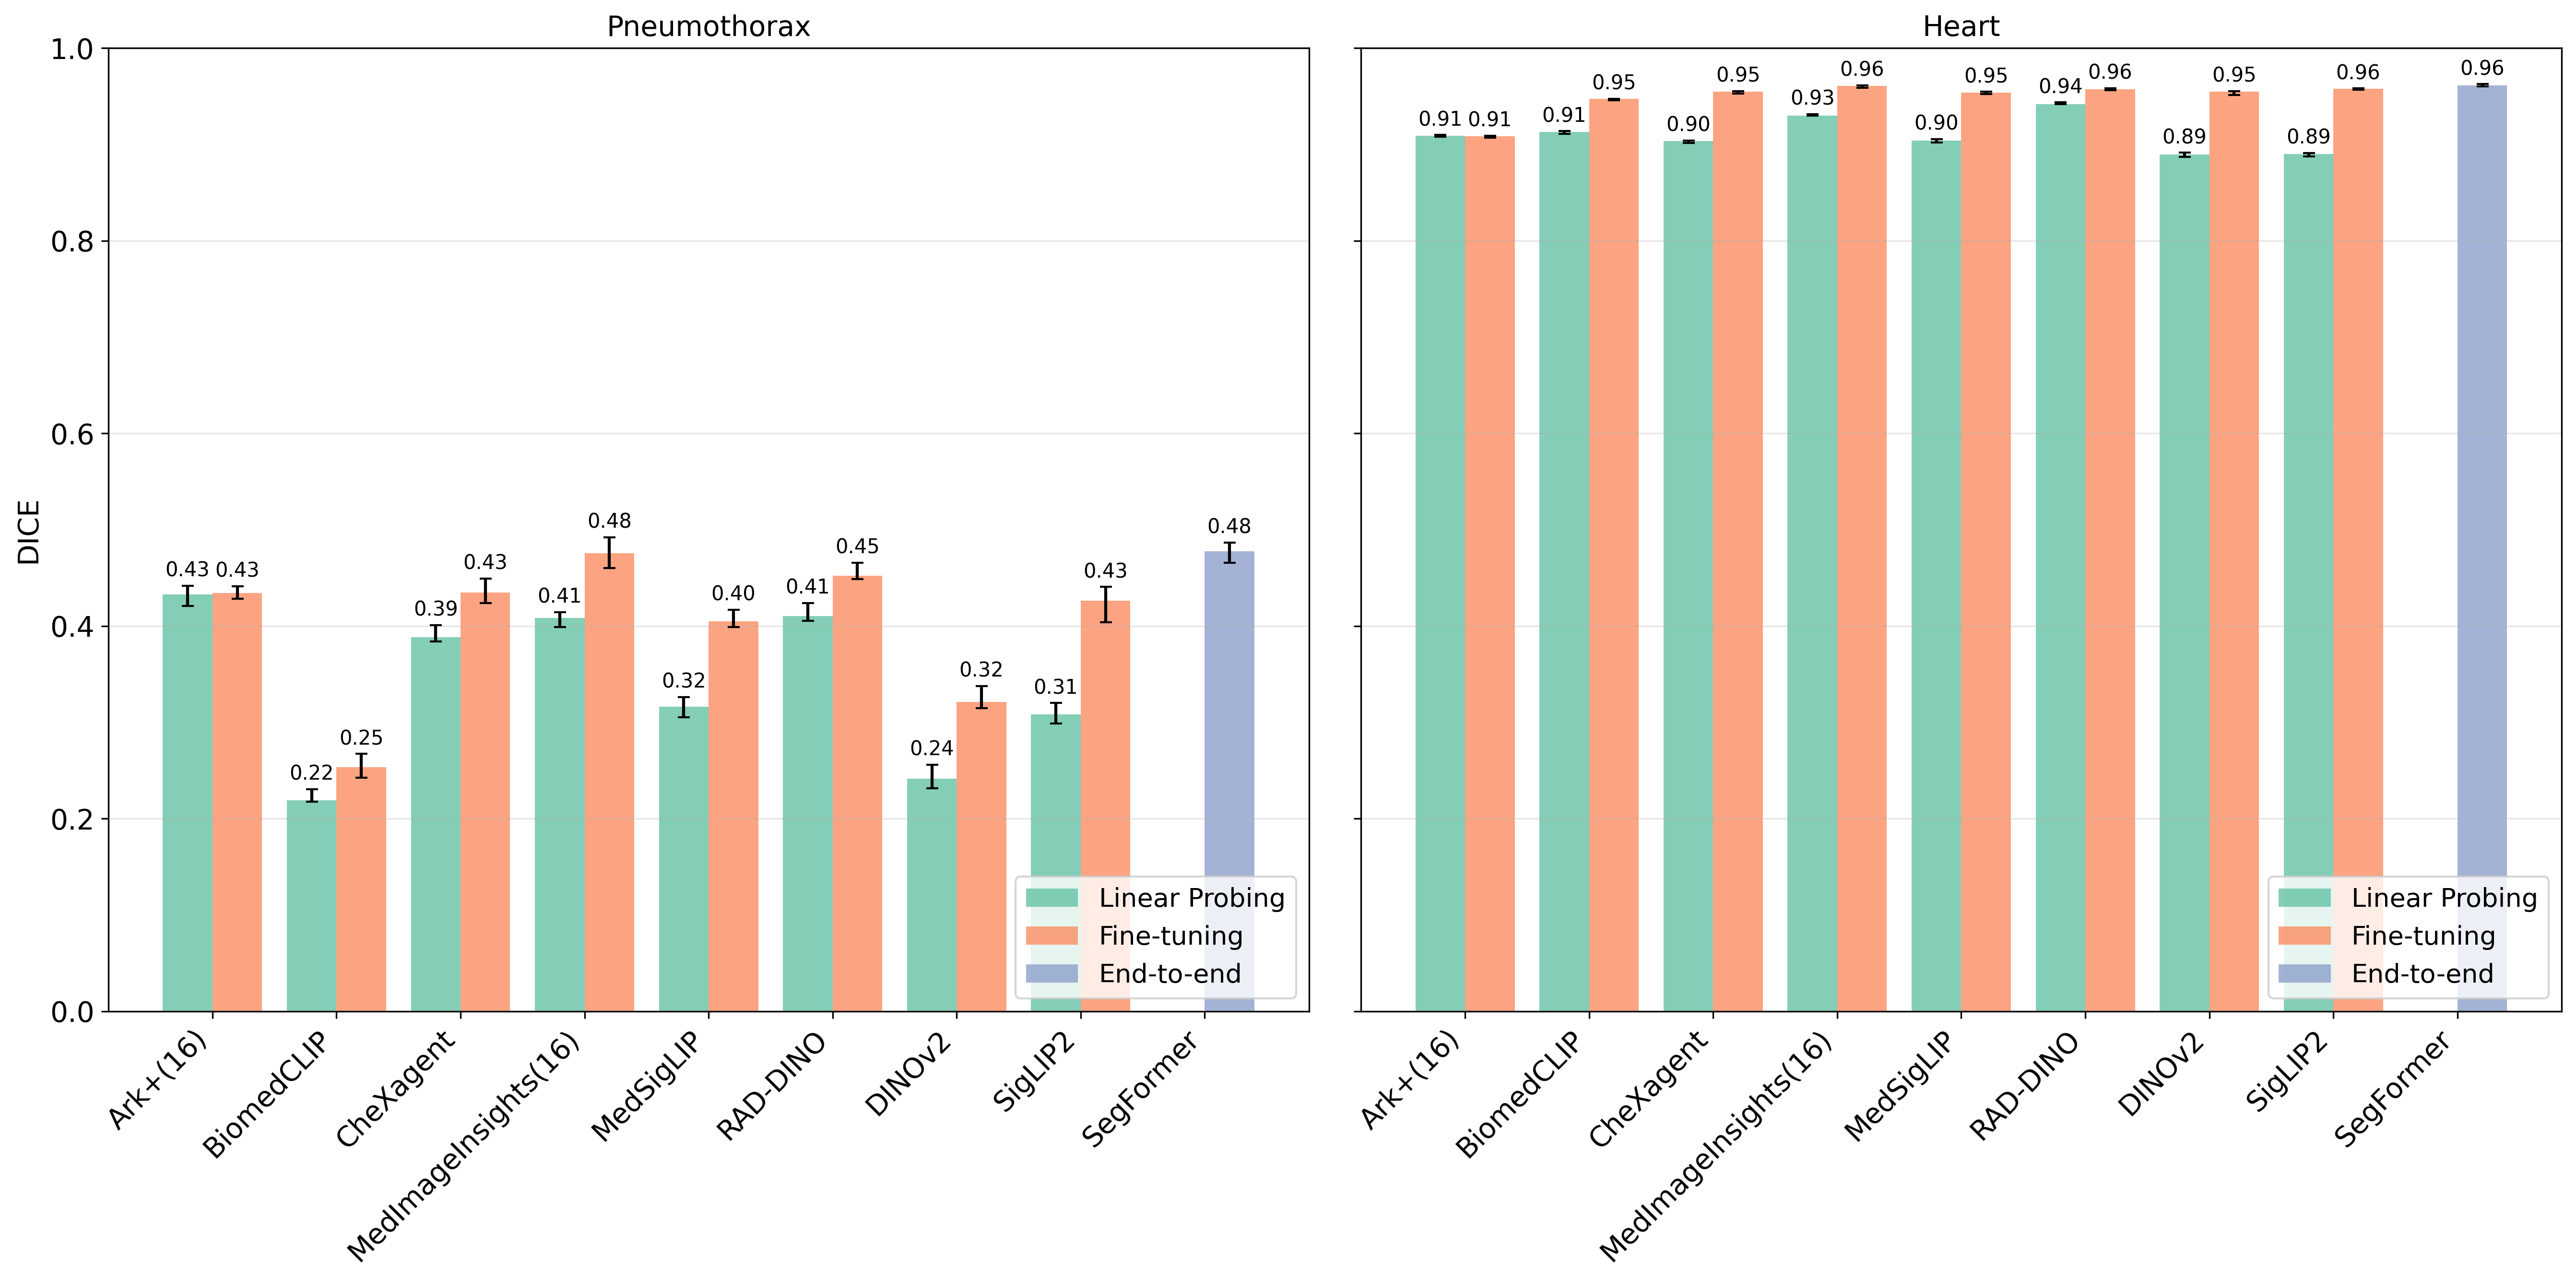

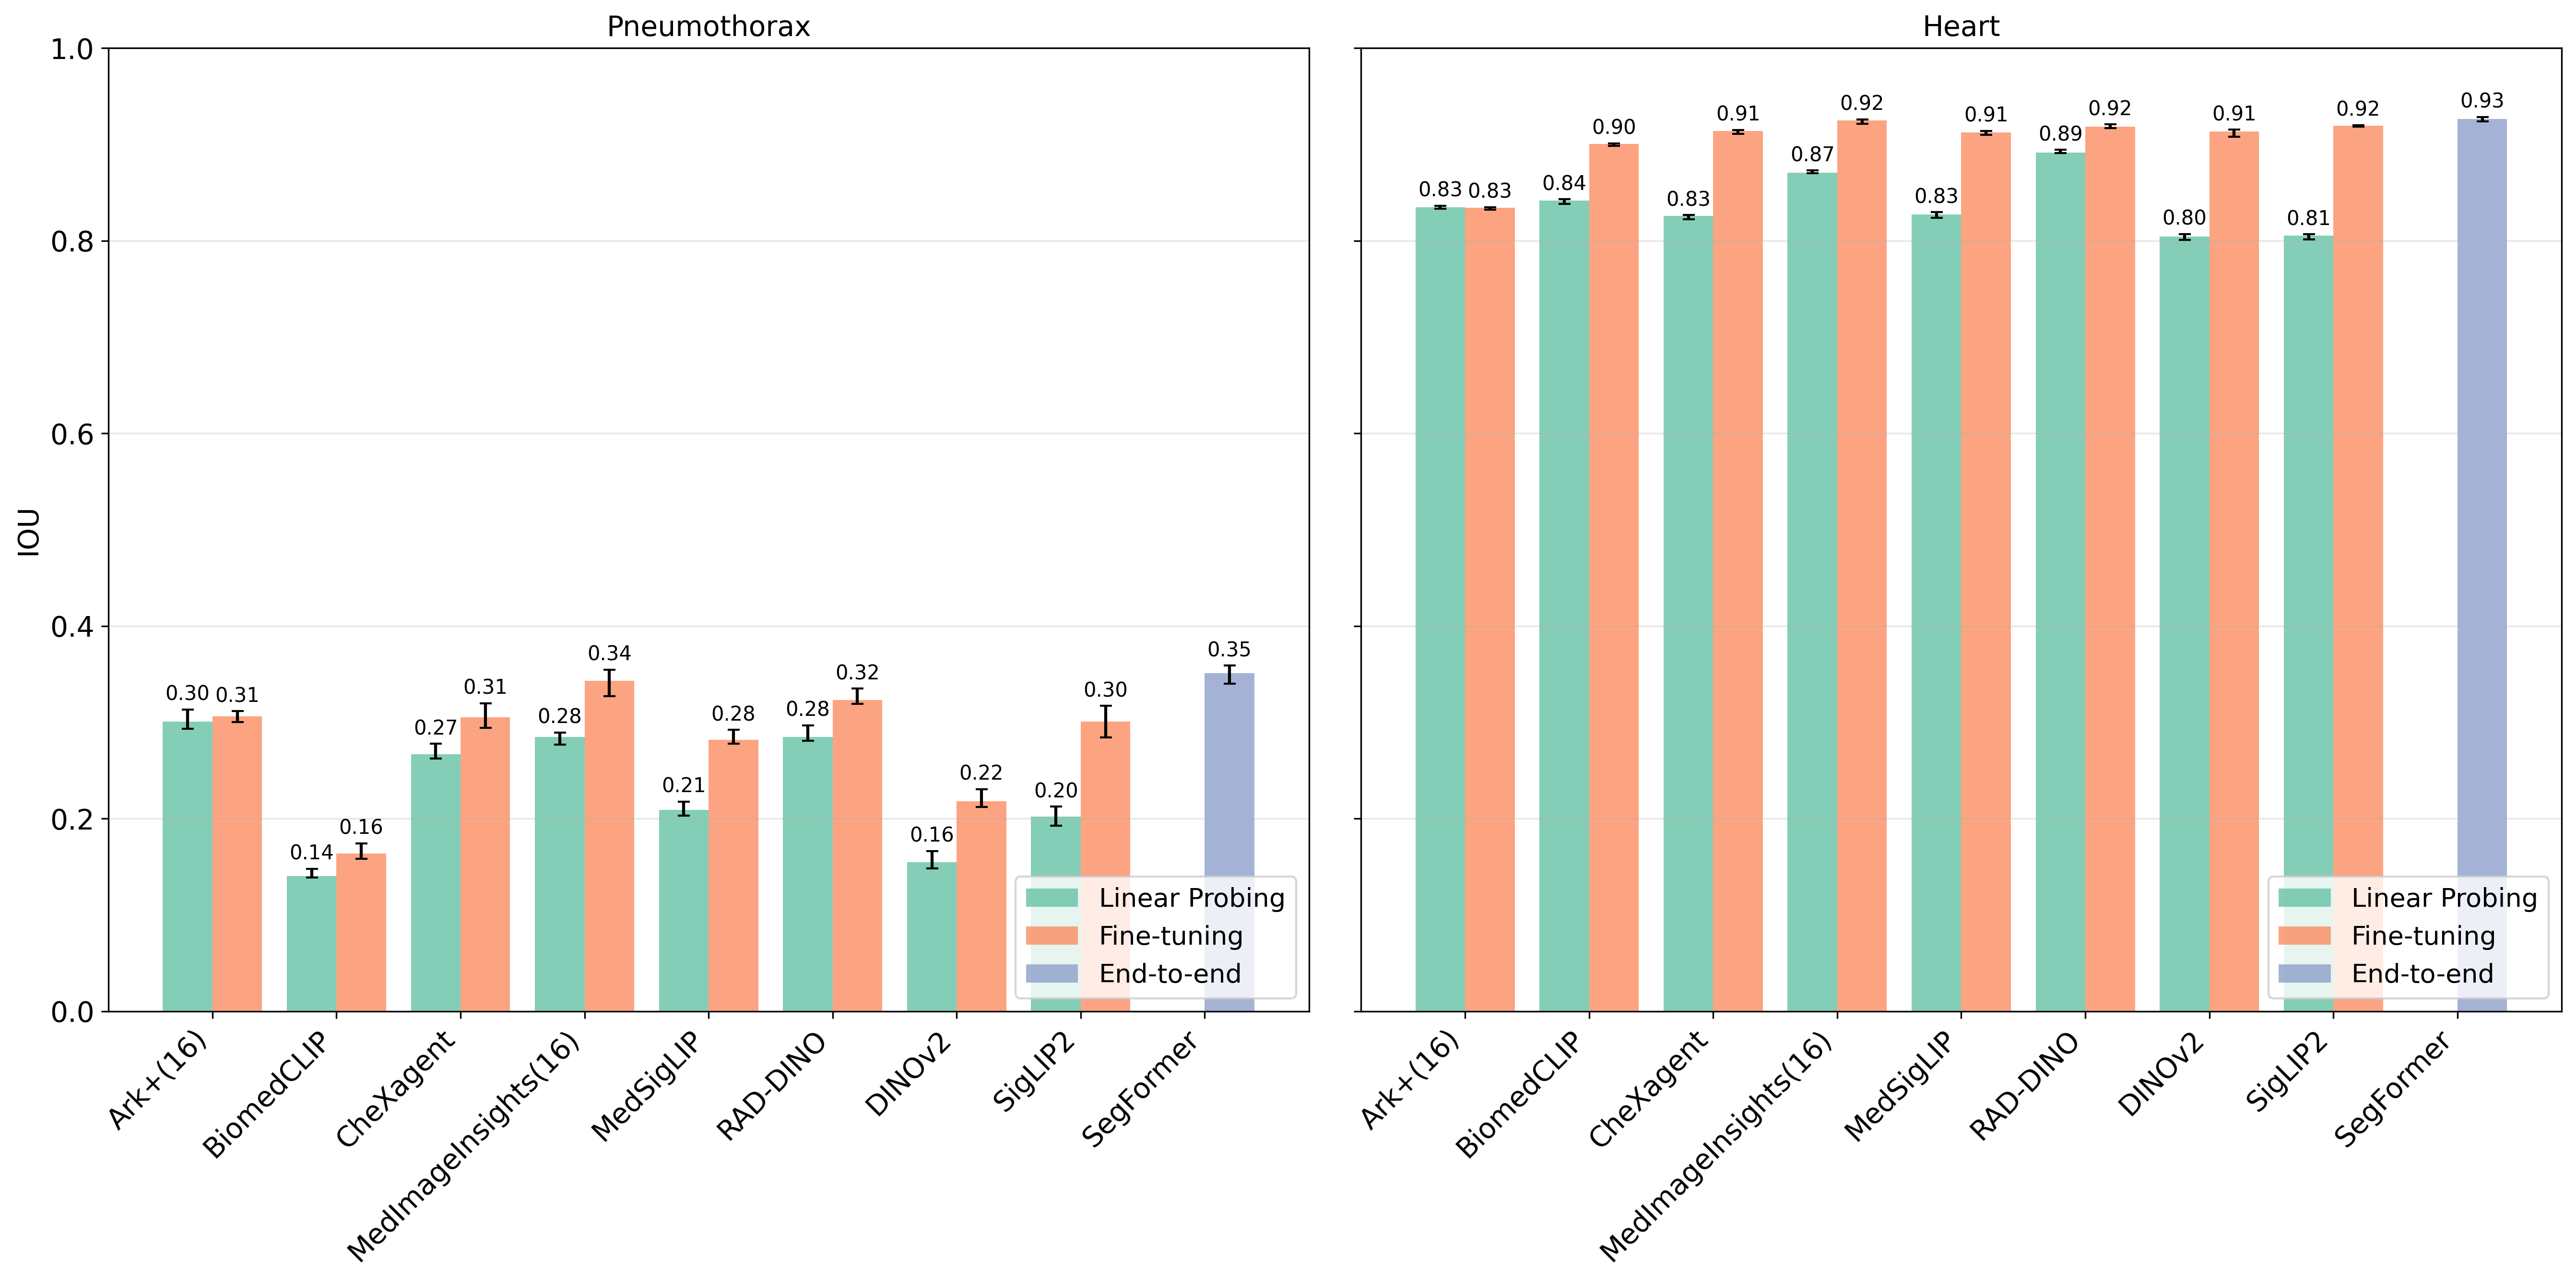


IOU Performance Comparison (Median)

Pneumothorax:
----------------------------------------
Model                | Linear Probing      | Fine-tuning        
----------------------------------------------------------------
Ark+(16)             | 0.301 (0.293-0.313) | 0.306 (0.300-0.312)
BiomedCLIP           | 0.140 (0.139-0.148) | 0.164 (0.158-0.174)
CheXagent            | 0.267 (0.262-0.278) | 0.305 (0.295-0.320)
MedImageInsights(16) | 0.285 (0.277-0.290) | 0.343 (0.327-0.355)
MedSigLIP            | 0.209 (0.203-0.218) | 0.282 (0.278-0.292)
RAD-DINO             | 0.285 (0.281-0.297) | 0.323 (0.319-0.335)
DINOv2               | 0.155 (0.148-0.167) | 0.218 (0.212-0.231)
SigLIP2              | 0.202 (0.193-0.212) | 0.301 (0.284-0.317)
SegFormer            | nan (nan-nan)       | 0.351 (0.340-0.359)

Heart:
----------------------------------------
Model                | Linear Probing      | Fine-tuning        
----------------------------------------------------------------
Ark+(16)     

In [10]:
plot_confidence_intervals_bars(seg_cv_results_dict0, font_size=14, metric='dice', ylim=(0.0,1.0), highlight_models=['SegFormer'], highlight_color=colors[2], highlight_label='End-to-end')
plot_confidence_intervals_bars(seg_cv_results_dict0, metric='iou', font_size=14, ylim=(0.0,1.0), highlight_models=['SegFormer'], highlight_color=colors[2], highlight_label='End-to-end')

#Print comparison tables
print_model_comparison_table(seg_cv_results_dict0, metric='iou')
print_model_comparison_table(seg_cv_results_dict0, metric='dice')

#save_model_comparison_table_csv(seg_cv_results_dict0, metric='iou', filename='./stats/iou_comparison_seg.csv')
save_model_comparison_table_csv(seg_cv_results_dict0, metric='dice', filename='./stats/3_dice_comparison_seg.csv')

### compare patch embeddings

In [24]:
results = aggregate_csvs(seg_csvs)
results['model_names'] = results.model.apply(lambda x: x.split('_')[0])

freeze_options = [1, 0]
freeze_dict = {1:'Linear Probing', 0:'Fine-tuning'}
target_options = ['pneumothorax','cardiomegaly']
target_dict = {'pneumothorax':'Pneumothorax','cardiomegaly':'Heart'}
model_options = ['Ark+(16)', 'Ark+(32)', 'MedImageInsights(16)', 'MedImageInsights(32)'] 

seg_cv_results_dict0 = {}

for t in target_options:
    seg_cv_results_dict1 = {}
    for m in model_options:
        seg_cv_results_dict2 = {}
        for f in freeze_options:
    
            sub_results = results[(results.model_names==m)&(results.freeze==f)&(results.target==t)]
            
            cv_results = calculate_cv_segmentation_metrics(sub_results)
    
            seg_cv_results_dict2[freeze_dict[f]] = cv_results
        seg_cv_results_dict1[m] = seg_cv_results_dict2
    seg_cv_results_dict0[target_dict[t]] = seg_cv_results_dict1

In [25]:
cv_scores_list = []
for t in ['Pneumothorax','Heart']:
    for m in model_options:
        for f in ['Linear Probing','Fine-tuning']:
            for p in ['dice','iou']:
                #print(m,f,p)
                #print(cla_cv_results_dict0[t][m][f][p]['fold_scores'])
                df_temp = pd.DataFrame(seg_cv_results_dict0[t][m][f][p]['fold_scores'], columns=['cv_scores'])
                df_temp['freeze'] = f
                df_temp['target'] = t
                df_temp['metric'] = p
                df_temp['model'] = m
                cv_scores_list.append(df_temp)

In [26]:
results_seg_patch = pd.concat(cv_scores_list, axis=0)
results_seg_patch.to_csv('./stats/3_cv_scores_seg_patch.csv', index=False)

In [27]:
def plot_confidence_intervals_bars2(results_dict, condition=None, metric='auroc', 
                                 figsize=(18, 9), font_size=14, palette='Set2',
                                 method_labels=None, ylim=None, save_path=None):
    """
    Plot confidence intervals for all models and methods using bar plots with methods as x-axis
    and model architectures as hue (different colored bars).
    
    Parameters:
    -----------
    results_dict : dict
        Nested dictionary with CV results (your current format)
    condition : str, optional
        Specific condition to plot. If None, plots all conditions
    metric : str
        Which metric to plot ('auroc', 'dice', 'iou', etc.)
    figsize : tuple
        Figure size (width, height)
    font_size : int or float
        Font size for all text elements in the plot
    palette : str, default 'Set2'
        Color palette for different model architectures
    method_labels : dict, optional
        Custom labels for methods {'Linear Probing': 'LP', 'Fine-tuning': 'FT'}
    ylim : tuple, optional
        Y-axis limits (min, max). If None, uses automatic scaling based on data
    save_path : str, optional
        Path to save the plot
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Default method labels
    if method_labels is None:
        method_labels = {'Linear Probing': 'Linear Probing', 'Fine-tuning': 'Fine-tuning'}
    
    conditions_to_plot = [condition] if condition else list(results_dict.keys())
    
    # Create subplots
    n_conditions = len(conditions_to_plot)
    n_cols = min(3, n_conditions)  # Max 3 columns
    n_rows = (n_conditions + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False, sharey=True, dpi=300)
    
    for idx, cond in enumerate(conditions_to_plot):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        models = list(results_dict[cond].keys())
        all_methods = list(results_dict[cond][models[0]].keys())
        
        # Ensure Linear Probing comes before Fine-tuning
        methods = []
        if 'Linear Probing' in all_methods:
            methods.append('Linear Probing')
        if 'Fine-tuning' in all_methods:
            methods.append('Fine-tuning')
        # Add any other methods that might exist
        for method in all_methods:
            if method not in methods:
                methods.append(method)
        
        # Create color palette for model architectures
        colors = sns.color_palette(palette, len(models))
        color_map = dict(zip(models, colors))
        
        # Set up positions - now methods are on x-axis
        x_positions = np.arange(len(methods))
        width = 0.8 / len(models)
        
        # Plot for each model architecture (now as hue)
        for i, model in enumerate(models):
            means = []
            ci_lower = []
            ci_upper = []
            model_positions = []
            
            for j, method in enumerate(methods):
                data = results_dict[cond][model][method][metric]
                means.append(data['median'])
                ci_lower.append(data['ci_lower'])
                ci_upper.append(data['ci_upper'])
                model_positions.append(x_positions[j] + i * width - width * (len(models) - 1) / 2)
            
            # Calculate error bars (distance from center to bounds)
            yerr_lower = np.array(means) - np.array(ci_lower)
            yerr_upper = np.array(ci_upper) - np.array(means)
            yerr = [yerr_lower, yerr_upper]
            
            # Plot bars with error bars
            bars = ax.bar(model_positions, means, width,
                         label=model,  # Now model is the legend label
                         color=color_map[model],
                         alpha=0.8,
                         capsize=3)
            
            # Add error bars
            ax.errorbar(model_positions, means,
                       yerr=yerr, fmt='none',
                       color='black', capsize=3, capthick=1)
            
            # Add value labels on bars
            for j, (pos, mean_val, upper_val) in enumerate(zip(model_positions, means, ci_upper)):
                ax.text(pos, upper_val + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.02, 
                       f'{mean_val:.2f}',
                       ha='center', va='bottom', fontsize=font_size-4, rotation=0)
        
        # Customize subplot
        if idx == 0:  # Only add ylabel to the first subplot
            ax.set_ylabel(metric.upper(), fontsize=font_size)
        
        ax.set_title(f'{cond}', fontsize=font_size)
        ax.set_xticks(x_positions)
        # Use method labels for x-axis
        method_x_labels = [method_labels.get(method, method) for method in methods]
        ax.set_xticklabels(method_x_labels, fontsize=font_size)
        ax.tick_params(axis='both', which='major', labelsize=font_size)
        ax.grid(True, alpha=0.3, axis='y')
        ax.legend(loc='lower right', fontsize=font_size)
        
        # Set y-axis limits
        if ylim is not None:
            ax.set_ylim(ylim)
        else:
            # Automatic y-axis limits for better visualization
            all_values = []
            for model in models:
                for method in methods:
                    data = results_dict[cond][model][method][metric]
                    all_values.extend([data['ci_lower'], data['ci_upper']])
            
            margin = (max(all_values) - min(all_values)) * 0.05
            ax.set_ylim(min(all_values) - margin, max(all_values) + margin * 2.5)  # Extra margin on top for labels
    
    # Hide empty subplots
    total_subplots = n_rows * n_cols
    for idx in range(n_conditions, total_subplots):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig, axes

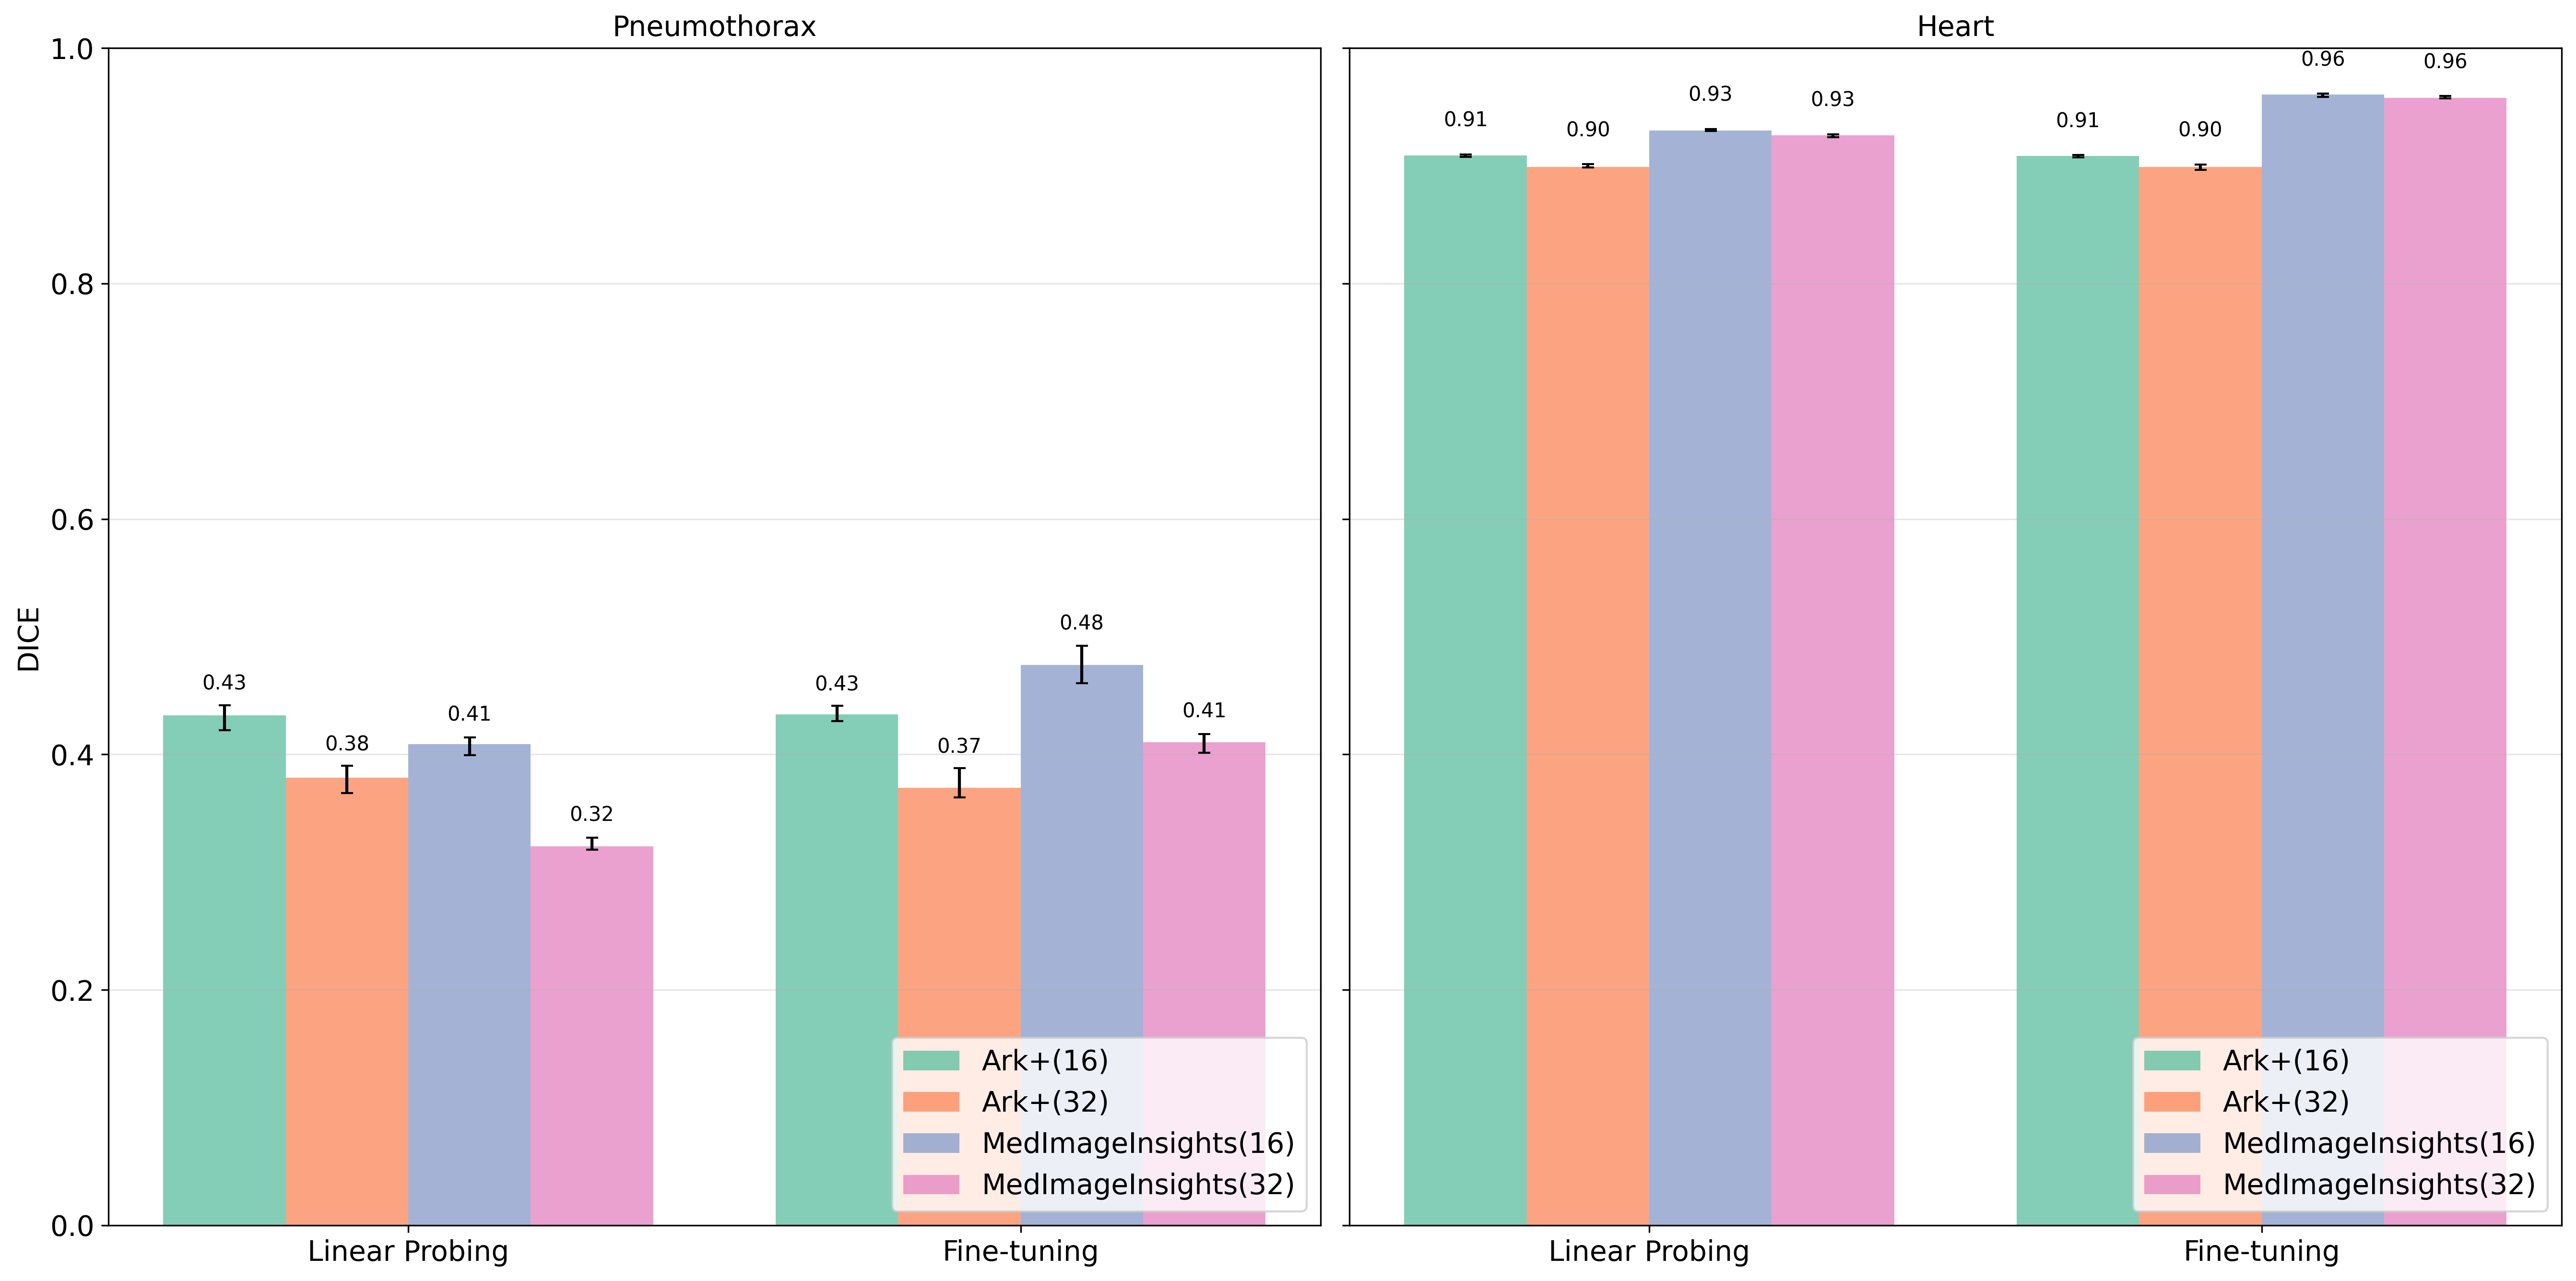

(<Figure size 5400x2700 with 2 Axes>,
 array([[<Axes: title={'center': 'Pneumothorax'}, ylabel='DICE'>,
         <Axes: title={'center': 'Heart'}>]], dtype=object))

In [28]:
plot_confidence_intervals_bars2(seg_cv_results_dict0, metric='dice', ylim=(0.0,1.0))

In [31]:
#Print comparison tables
#print_model_comparison_table(seg_cv_results_dict0, metric='iou')
print_model_comparison_table(seg_cv_results_dict0, metric='dice')


DICE Performance Comparison (Median)

Pneumothorax:
----------------------------------------
Model                | Linear Probing      | Fine-tuning        
----------------------------------------------------------------
Ark+(16)             | 0.433 (0.421-0.442) | 0.434 (0.428-0.441)
Ark+(32)             | 0.380 (0.367-0.390) | 0.372 (0.363-0.388)
MedImageInsights(16) | 0.409 (0.399-0.415) | 0.476 (0.460-0.492)
MedImageInsights(32) | 0.322 (0.319-0.329) | 0.410 (0.401-0.417)

Heart:
----------------------------------------
Model                | Linear Probing      | Fine-tuning        
----------------------------------------------------------------
Ark+(16)             | 0.909 (0.908-0.910) | 0.908 (0.907-0.909)
Ark+(32)             | 0.899 (0.898-0.901) | 0.899 (0.896-0.901)
MedImageInsights(16) | 0.930 (0.930-0.931) | 0.961 (0.959-0.961)
MedImageInsights(32) | 0.926 (0.924-0.927) | 0.958 (0.957-0.959)


In [32]:
save_model_comparison_table_csv(seg_cv_results_dict0, metric='dice', filename='./stats/3_dice_comparison_seg_patch.csv')

Table saved as ./stats/3_dice_comparison_seg_patch.csv (using median)
